# PHY204 – 1D solver using Numerov's method
----

## Test on the example from Hu, page 74

Quoting from the article by Hu (page 74):

> *We now consider as an example a medium in which $n_{\max}=1.45$ and $n_{\min}=0.96n_{\max}=1.39$. The width in the center region is chosen so that $k_0a(n_1^2 −n_0^2)^{1/2}=1$, which
implies $a=0.39\lambda$. There is only one guided mode, and we consider a
Gaussian input beam $A(z=0,x)=A_0\exp{\left(-x^2/2a^2\right)}$ , where $a$ is half the width of
the central layer. In this example, 70% of the initial power is in the guided mode, and the rest is in the radiation modes.*

The aim of this notebook is to test the implementation on this example.

### Implementation: 1D modes with $A(x)\to 0$ as $x\to\pm\infty$ 

*Credit: This method of solving the differential equation (with Numerov's method and both foward and backward integration) is adapted from a notebook we received from Prof. Couairon, whose aim was to solve the Schrödinger equation.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

In [2]:
no_points = 5000
lbda = 1e-6
c = 3e8
omega = 2 * np.pi * c / lbda
    
class Numerov:
    
    l_0 = c / omega
    k_0 = 1 / l_0
    eps = 0.001
    
    def __init__(self, refr_index, N, b, a):
        self.N = N
        self.x_min = - b * omega / c
        self.x_max = b * omega / c
        self.x = np.linspace(self.x_min, self.x_max, N)
        self.a = a
        self.b = b
        self.y = np.zeros(N)
        self.step = self.x[1]-self.x[0]
        self.refr_index = np.vectorize(refr_index, otypes=[float])(self.x * c / (b * omega))
        # the refractive index has to be specified for x from -1 to 1 (normalized to the width of the fiber)
    
    def plot_index(self):
        plt.figure(figsize=(8, 3))
        plt.plot(self.x * c / omega * 1e6, self.refr_index, label='$n(x)$')
        plt.xlabel('position $x$ [µm]')
        plt.ylabel('index of refraction $n(x)$')
        plt.title('Index of refraction profile')
        plt.legend()
        plt.show()
    
    def forward_numerov(self, ind, v1, v2, n_max, K):
        self.y[ind] = v1
        self.y[ind+1] = v2
        W = (K ** 2 - self.refr_index ** 2)
        fact = self.step**2 / 12.
        for i in range(ind+2, n_max+1):
            self.y[i] = (2*self.y[i-1] - self.y[i-2] \
                         + fact*(10*W[i-1]*self.y[i-1] + W[i-2]*self.y[i-2])) / (1-W[i]*fact)
                
    def backward_numerov(self, ind, v1, v2, n_min, K):
        self.y[ind] = v1
        self.y[ind-1] = v2
        W = (K ** 2 - self.refr_index ** 2)
        fact = self.step**2 / 12.
        for i in range(ind-2, n_min-1, -1):
            self.y[i] = (2*self.y[i+1] - self.y[i+2] \
                         + fact*(10*W[i+1]*self.y[i+1] + W[i+2]*self.y[i+2])) / (1-W[i]*fact)
            
    def get_boundary(self, K):
        n_match = 0
        for i in range(0, self.N-1):
            if (self.refr_index[i]-K)*(self.refr_index[i+1]-K) < 0:
                n_match = i
        return n_match
    
    def get_mismatch(self, K):
        n_match = self.get_boundary(K)
        self.forward_numerov(0, 0.0, self.eps, n_match+1, K)
        slope_l = (self.y[n_match+1] - self.y[n_match-1]) / self.y[n_match]
        self.backward_numerov(self.N-1, 0.0, self.eps, n_match-1, K)
        slope_r = (self.y[n_match+1] - self.y[n_match-1]) / self.y[n_match]
        return slope_r - slope_l

    def plot_solution(self, K, show=True):
        # the show parameter controls if the solutions are all plotted on the same graph or not
        n_match = self.get_boundary(K)
        self.forward_numerov(0, 0.0, self.eps, n_match, K)
        self.y[0:n_match+1] /= self.y[n_match]
        self.backward_numerov(self.N-1, 0.0, self.eps, n_match, K)
        self.y[n_match:self.N] /= self.y[n_match]
        plt.xlim(self.x_min * c / omega * 1e6, self.x_max * c / omega * 1e6)
        if np.max(np.abs(self.y)) < 100:
            plt.plot(self.x * c / omega * 1e6, self.y, label=f'$h = {round(K, 3)}\kappa_0$')
            plt.xlabel('position $x$ [µm]')
            plt.ylabel('amplitude $E(x)$')
            if show:
                plt.show()

    def plot_solution_normalized(self, K, show=True, full=False):
        # the show parameter controls if the solutions are all plotted on the same graph or not
        n_match = self.get_boundary(K)
        self.forward_numerov(0, 0.0, self.eps, n_match, K)
        self.y[0:n_match+1] /= self.y[n_match]
        self.backward_numerov(self.N-1, 0.0, self.eps, n_match, K)
        self.y[n_match:self.N] /= self.y[n_match]
        if full:
            plt.xlim(self.x_min * c / omega * 1e6, self.x_max * c / omega * 1e6)
        else:
            plt.xlim(-3 * self.a * 1e6, 3 * self.a * 1e6)
        if np.max(np.abs(self.y)) < 1e2:
            plt.plot(self.x * c / omega * 1e6, self.y / max(np.abs(self.y)), label=f'$h = {round(K, 3)}\,\kappa_0$')
            plt.xlabel('position $x$ [µm]')
            plt.ylabel('amplitude $E(x)$')
            if show:
                plt.show()
            return True
        return False
    
    def solution_normalized(self, K):
        n_match = self.get_boundary(K)
        self.forward_numerov(0, 0.0, self.eps, n_match, K)
        self.y[0:n_match+1] /= self.y[n_match]
        self.backward_numerov(self.N-1, 0.0, self.eps, n_match, K)
        self.y[n_match:self.N] /= self.y[n_match]
        return self.y / max(np.abs(self.y))

    def find_eigenmodes_brentq(self, K_min, K_max):
        # this one only returns one eigenmode at a time and the range needs to be narrowed down manually
        return brentq(self.get_mismatch, K_min, K_max)
    
    def find_eigenmodes_discretely(self, K_min, K_max):
        # this finds all the roots of the discretized solution
        wavenumber_range = np.linspace(K_min, K_max, no_points)
        mismatch = np.array([numerov.get_mismatch(K) for K in wavenumber_range])
        n_match = []
        for i in range(0, self.N-1):
            if (mismatch[i])*(mismatch[i+1]) < 0:
                n_match.append(self.find_eigenmodes_brentq(wavenumber_range[i], wavenumber_range[i+1]))
        return n_match
    
    def plot_eigenmodes(self, K_min, K_max, full=False, show=True):
        plt.figure(figsize=(8,5))
        wavenumber_range = np.linspace(K_min, K_max, no_points)
        K_modes = self.find_eigenmodes_discretely(K_min, K_max)
        K_valid = []
        for K in K_modes:
            valid = self.plot_solution_normalized(K, show=False, full=full)
            if valid:
                K_valid.append(K)
        plt.title(f'Eigenmodes in the range ${round(K_min, 3)}\kappa_0 < h < {round(K_max, 2)}\kappa_0$')
        if show:
            plt.legend()
            plt.show()
        return K_valid
    
    def theoretical_allowed_modes(self):
        # this should only be used for the classical n_1 and n_2 (constant) waveguide, or for the supergaussian
        n_min = min(self.refr_index)
        n_max = max(self.refr_index)
        radius = self.a * np.sqrt(n_max**2 - n_min**2) * omega / c
        agamma_1 = np.linspace(0, radius, 3000)
        larger_agamma_1 = np.linspace(0, 1.5*radius, 3000)
        y1 = np.tan(larger_agamma_1)
        y2 = -1/np.tan(larger_agamma_1)
        circle = np.sqrt(radius**2 - agamma_1**2)
        plt.plot(agamma_1, circle, lw=3, c='red', label=r'$\gamma_1^2+\gamma_2^2=(n_1^2-n_2^2)\frac{\omega^2}{c^2}$')
        plt.scatter(larger_agamma_1, y1, marker='.', label='even solutions')
        plt.scatter(larger_agamma_1, y2, marker='.', label='odd solutions')
        plt.xlim([0, 1.5 * radius])
        plt.ylim([0, 1.5 * radius])
        plt.xlabel('$\gamma_1 a$')
        plt.ylabel('$\gamma_2 a$')
        plt.title('Theoretically allowed modes for the optical fiber')
        plt.legend()
        plt.show()

In [3]:
J = lambda f_1, f_2, width: width * sum(f_1 * f_2) / (f_1.size - 1)

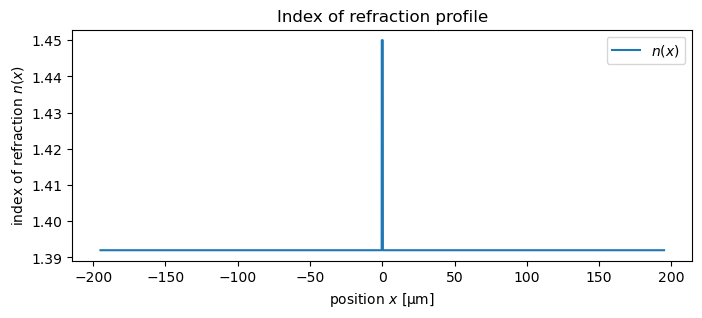

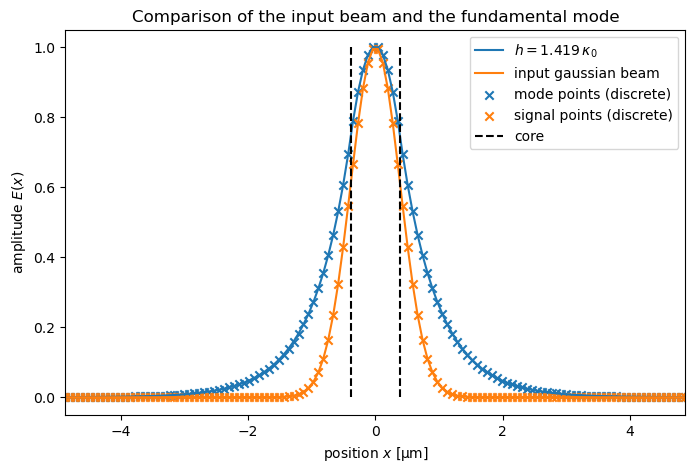

c_1 =  0.8039523399931991 ; contribution:  91.43553261869032 %


In [4]:
def input_beam(half_width):
    return lambda x: np.exp(-x ** 2 / (2 * half_width ** 2))

b = 195e-6
core_fraction = 0.39 * lbda / b
n_max = 1.45
n_min = 0.96 * n_max
x_arr = np.linspace(-b * 1e6, b * 1e6, no_points)
index_n = lambda x: n_max if abs(x) <= core_fraction else n_min

numerov = Numerov(index_n, no_points, b, core_fraction * b)
numerov.plot_index()
# numerov.theoretical_allowed_modes()
arr_K_vals = numerov.plot_eigenmodes(n_min + 0.00001, n_max - 0.00001, full=False, show=False)[::-1]
arr_K_modes = np.array([numerov.solution_normalized(v) for v in arr_K_vals])

# def compute_contribution(fiber, modes, signal, mode_number, rel_width, plot=True):
#     number_pts_core = int(no_points * fiber.b / fiber.b)
#     x_arr = np.linspace(-fiber.a * 1e6, fiber.a * 1e6, number_pts_core)
#     signal_arr = np.array([signal(1e6 * fiber.a * rel_width)(x) for x in x_arr])
#     if plot:
#         plt.plot(x_arr, signal_arr, label='input beam')
#         plt.xlim(-3 * core_fraction * fiber.b * 1e6, 3 * core_fraction * fiber.b * 1e6)
#         plt.legend()
#         plt.show()
#     mode_core = modes[mode_number-1][(fiber.N - number_pts_core) // 2:(fiber.N + number_pts_core) // 2]
#     coeff = J(signal_arr, mode_core, fiber.a) / \
#                 J(mode_core, mode_core, fiber.a)
#     E_norm2 = J(signal_arr, signal_arr, fiber.a)
#     contrib = coeff ** 2 * J(mode_core, mode_core, fiber.a) / E_norm2
#     return coeff, contrib

def compute_contribution(fiber, modes, signal, mode_number, rel_width, plot=True):
    x_arr = np.linspace(-fiber.b * 1e6, fiber.b * 1e6, no_points)
    m = modes[mode_number-1]
    m_core = []
    x_core_mode = []
    for idx, value in enumerate(m):
        if abs(x_arr[idx]) <= fiber.b * 1e6 / 10:
            m_core.append(value)
            x_core_mode.append(x_arr[idx])
    M = np.array(m_core)
    X_M = np.array(x_core_mode)
    signal_arr = np.array([signal(1e6 * fiber.a * rel_width)(x) for x in x_arr])
    s_core = []
    x_core_signal = []
    for idx, value in enumerate(signal_arr):
        if abs(x_arr[idx]) <= fiber.b * 1e6 / 10:
            s_core.append(value)
            x_core_signal.append(x_arr[idx])
    S = np.array(s_core)
    X_S = np.array(x_core_signal)
#     print(S, M, X_M, X_S)

    if plot:
        plt.plot(x_arr, signal_arr, label='input gaussian beam')
        plt.scatter(X_M, M, marker='x', label='mode points (discrete)')
        plt.scatter(X_S, S, marker='x', label='signal points (discrete)')
        plt.xlim(-1.5 * fiber.b * 1e6 / 60, 1.5 * fiber.b * 1e6 / 60)
        plt.vlines(-fiber.a * 1e6, 0, 1, linestyles='dashed', colors='black')
        plt.vlines(fiber.a * 1e6, 0, 1, linestyles='dashed', colors='black', label='core')
        plt.title('Comparison of the input beam and the fundamental mode')
        plt.legend()
        plt.show()

    coeff = J(S, M, fiber.b / 10) / J(M, M, fiber.b / 10)
    E_norm2 = J(S, S, fiber.b / 10)
    E_norm2 = J(signal_arr, signal_arr, fiber.b)
    contrib = coeff ** 2 * J(m, m, fiber.b) / E_norm2
    return coeff, contrib

c_1, contrib_1 = compute_contribution(numerov, arr_K_modes, input_beam, 1, 1, plot=True)
print('c_1 = ', c_1, '; contribution: ', contrib_1*100, '%')

<!-- $$\mathbf{\color{red}{{\text{Contrary to the claim in the book, we find 90% of the power in the fundamental mode, not only 70%!}}}}$$ -->

To verify the way we implemented the mode decomposition, we ran the Matlab code of the authors, which is available [online](https://figshare.com/articles/dataset/Media_9_Understanding_leaky_modes_slab_waveguide_revisited/4910813), in the file `ThreeLayerGetCouplingCoeff.m`. They obtained a value of `c_1 = 0.8082`. Therefore, we conclude that the *coupling coefficient* between the input gaussian beam and the fundamental mode is indeed correct to two significant digits, with the difference being justified by the different number of points in the grid. However, we find a power of around 90%, contrary to what the authors quoted, 70%. Since we couldn't find any reference in the code about how this percentage was computed, we cannot verify the validity of the author's claim. The discrepancy may be caused by a different range of integration along the $x$-axis.